# AST 390 Final Project

In [143]:
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants as const
from astropy import units as u
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

Create empty arrays and variables

In [144]:
num_galaxies = 1000

gal_len = [] #lensed galaxies
gal_src = [] #source galaxies


counter = 0 
index = 0 

e1 = np.zeros([num_galaxies,1], dtype ='cfloat') # Intrinsic ellipticities
e_s = np.zeros([num_galaxies,1], dtype ='cfloat') # Intrinsic ellipticities
eg = np.zeros([num_galaxies,1], dtype = 'cfloat') # Complex shear
ef1 = np.zeros([num_galaxies,1], dtype = 'cfloat') # Final ellipticities
r = np.zeros([num_galaxies, 1], dtype = 'f') # Magnitude of position vector
g = np.zeros([num_galaxies,1], dtype = 'f') # Magnitude of gamma, or shear effect
R = np.zeros([num_galaxies,1], dtype = 'f') # Ratio of major and minor axes for lensed galaxies
R0 = np.zeros([num_galaxies,1], dtype = 'f') # Ratio of major and minor axes for source galaxies
phi = np.zeros([num_galaxies,1], dtype = 'f') #  Position angle wrt x-axis
major = np.zeros([num_galaxies, 1], dtype = 'f') # Major axis of lensed galaxies
major0 = np.zeros([num_galaxies, 1], dtype = 'f') # Major axis of source galaxies
minor = np.zeros([num_galaxies, 1], dtype = 'f') # Minor axis of lensed galaxies
minor0 = np.zeros([num_galaxies, 1], dtype = 'f') # Major axis of lensed galaxies
theta = np.zeros([num_galaxies, 1], dtype = 'f') # Angle of lensed galaxies
theta0 = np.zeros([num_galaxies, 1], dtype = 'f') # Angle of source galaxies

Initial parameters

In [145]:
z1=0.2 #redshift of lensing halo
z2=1  #redshift of source
c=5 #concentration
r200= 3 # virial radius in Mpc
mu, sigma = 0, 0.3 # average and std for generating random ellipticities

Constants

In [146]:
Mpc=3.08567758*10**22 #meters in a meter
clight=(const.c).value/Mpc # speed of light converted from m/s to Mpc/s
Ds = (cosmo.angular_diameter_distance(z2)).value # distance of sourse galaxies in Mpc
Dd = (cosmo.angular_diameter_distance(z1)).value # distance of lensed galaxies in Mpc
Dds= (Ds*(1.+z2)-Dd*(1.+z1))/(1.+z2) # line-of-sight distance in Mpc between lensed galaxies and sourse galaxies
h=0.7 # dimensionless hubble constant
H0=1000.*100.*h/Mpc # hubble constant converted to s-1
G=(const.G).value/(Mpc**3) # gravitational constant converted from m3/(kg·s^2) to Mpc^3/(kg s^2)

Calculate $\delta_c$, $\Sigma_{crit}$, $\rho_{c}$, $\rho$, and $r_s$

In [147]:
delta_c=(200/3)*(c**3)/(np.log(1+c)-c/(1+c)) # overdensity 
Sigma_crit= (clight**2)/(4*np.pi*G)*(Ds/(Dd*Dds)) #critical surface mass density in kg/Mpc^2
rho_crit = 3*(H0*H0)/(8*np.pi*G)*((1+z1)**3) # critical density
r_s= r200/c #r_scale
kappa_k= (2*r_s*delta_c*rho_crit)/(Sigma_crit)

Function for calculating $\Sigma_{NFW}$

In [148]:
def Sigma(x): # surface mass density
    if x<1:
        return (1-(2/np.sqrt(1- x**2))*np.arctanh(np.sqrt((1-x)/(1.+x))))/(x**2-1)
    elif x==1:
        return 1/3
    elif x>1:
        return (1-(2/np.sqrt(x*x-1))*np.arctan(np.sqrt((x-1)/(x+1))))/(x*x-1)

Function for calculating ${\gamma}$

In [149]:
def Shear(x):
    if x<1:
        return kappa_k*((4*np.arctanh(np.sqrt((1-x)/(1+x)))/(x**2*np.sqrt(1-x**2)))+(2*np.log(x/2)/x**2)-(1/(x**2-1))+((2*np.arctanh(np.sqrt((1-x)/(1+x)))/((x**2-1)*np.sqrt(1-x**2)))))
    elif x==1:
        return kappa_k*(2*np.log(1/2)+(5/3))
    elif x>1:
        return kappa_k*((4*np.arctan(np.sqrt((x-1)/(1+x)))/(x**2*np.sqrt(x**2-1)))+(2*np.log(x/2)/x**2)-(1/(x**2-1))+((2*np.arctan(np.sqrt((x-1)/(1+x)))/((x**2-1)**(3/2)))))

Function for calculating $\kappa$

In [150]:
def kappa(x): #dimensionless surface mass density  unknown convergence due to the cluster surrounding the lensing galaxy
    return kappa_k*Sigma(x)

Function for calculating $g$

In [151]:
def G_calc(x): # reduced shear
    return Shear(x)/(1 - kappa(x))

Create model galaxies and dark matter

In [152]:
xy = np.zeros([1, 2])
position = [xy  for i in range(num_galaxies)] 

with open('data_new.csv', 'w+') as file:
    file.write('x-position'+ ',' +"y-position" + ',' + 'real part of ef' + ',' + 'imaginary part of ef' + ',' + 'reduced shear' + "\n")
    
    graphed = 0

    ei1, ei2 = np.random.normal(mu, sigma, num_galaxies), np.random.normal(mu, sigma, num_galaxies) 
    for ind in range(0, num_galaxies):
        e1[ind] = complex(ei1[ind], ei2[ind]) 

    while counter < num_galaxies:

        xy = np.array([np.random.uniform(-2,2), np.random.uniform(-2,2)])
        position[counter] = [xy] 
        r[counter] = np.sqrt(xy[0]**2 + xy[1]**2) 
        y = r[counter]/(r_s) # Dimensionless parameter
        phi[counter] = np.arctan2(xy[1],xy[0])    
     
        g[counter] = G_calc(y) 
    
        eg[counter] = complex(-g[counter]*np.cos(2.*phi[counter]), -g[counter]*np.sin(2.*phi[counter])) 
 
        ef1[counter] = (e1[counter]+eg[counter])/(1 + np.conjugate(eg[counter])*e1[counter])
    

        theta[counter] = .5*np.angle(complex(ef1[counter].real, ef1[counter].imag), deg = 'true')
        theta0[counter] = .5*np.angle(complex(e1[counter].real, e1[counter].imag), deg = 'true')
        
        mag = abs(ef1[counter]) # magnitude of complex number
        mag0 = abs(e1[counter])
   
        R[counter] = (1.-mag)/(1.+mag)
        R0[counter] = (1.-mag0)/(1.+mag0)

        a = np.random.rand(1)*.05
    
        minor[counter] = a
        major[counter] = minor[counter]/R[counter]
        minor0[counter] = a
        major0[counter] = minor0[counter]/R0[counter]
        if mag <= .8: 
            if r[counter] >= .05:
                s = "{:>10},{:>10},{:>10},{:>10},{:>10}\n".format('%.5f'%(xy[0]), '%.5f'%(xy[1]),'%.5f'%(ef1[counter][0].real) ,'%.5f'%(ef1[counter][0].imag),'%5f'%(g[counter]))        
                file.write(s)
                gal_src.append(Ellipse(xy, major0[counter], minor0[counter], theta0[counter])) # source galaxies
                gal_len.append(Ellipse(xy, major[counter], minor[counter], theta[counter])) # lensed galaxies
                graphed += 1
        counter += 1 

Plot source galaxies and lensed galaxies

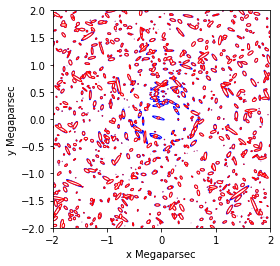

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
dark_matter = Ellipse(np.array([0,0]),r_s,r_s,0)

for e in gal_len:
    ax.add_artist(e)
    e.set_facecolor('white')
    e.set_edgecolor('blue')

for w in gal_src:
    ax.add_artist(w)
    w.set_facecolor('white')
    w.set_edgecolor('red')
    
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('x Megaparsec')
ax.set_ylabel('y Megaparsec')

plt.savefig('darkmattermodel.png', dpi = 200)
plt.show()
